In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import wave
import webrtcvad
import torch
from jupyterplot import ProgressPlot
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
torch.set_num_threads(1)
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"

plt.rcParams['figure.dpi'] = 300

# Loading File and its Framing from IEMOCAP

Sample Rate: 16000 Hz


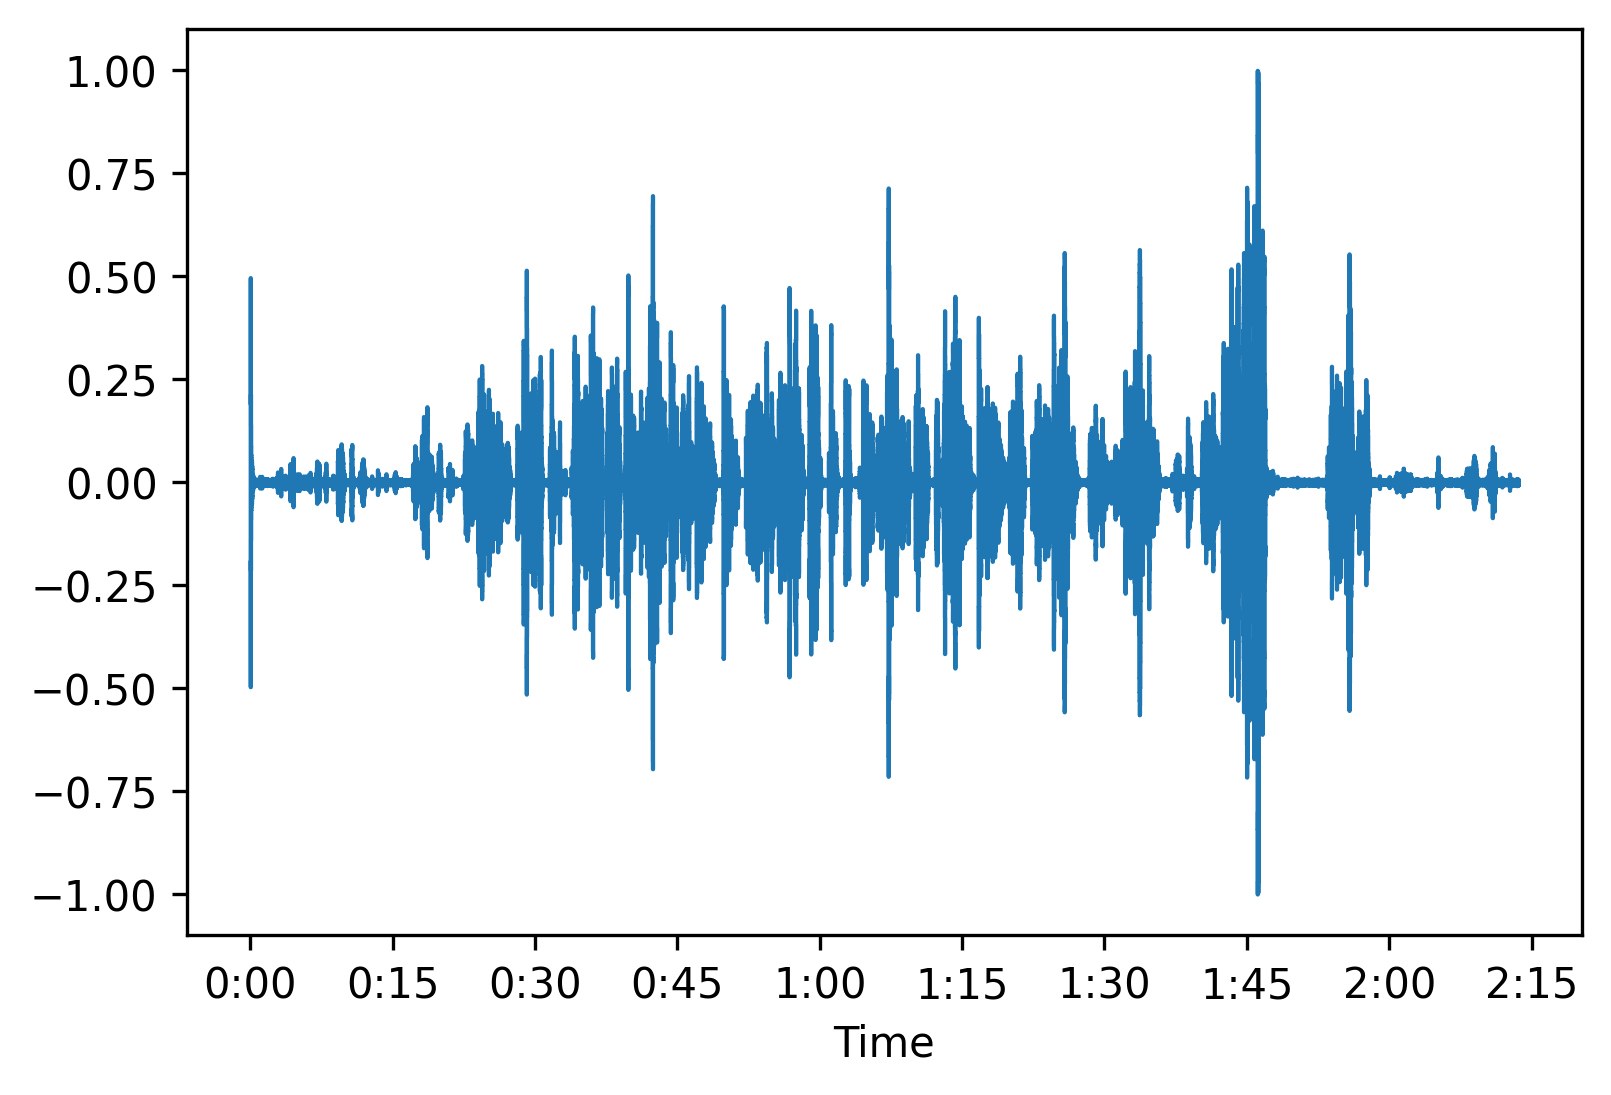

In [2]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01F_impro01.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y, sr=sr)
print(f"Sample Rate: {sr} Hz")
plt.show()

In [3]:
all_voiced_frames = []
male_voiced_frames = []
female_voiced_frames = []
with open(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt') as emotions_test_file:
    for line in emotions_test_file:
        if line[0] == '[':
            args = line.split()
            if 'M' == args[3][-4]:
                male_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            else:
                female_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            all_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
all_voiced_frames.sort(key=lambda x: x[0])

In [4]:
# These have both female and male actors speech times
print(f"Number of separate actors voice frames: {len(all_voiced_frames)}")
print(all_voiced_frames)

Number of separate actors voice frames: 30
[(6.2901, 8.2357), (7.5712, 10.475), (10.01, 11.3925), (10.9266, 14.6649), (14.8872, 18.0175), (16.8352, 19.7175), (19.29, 20.7875), (21.3257, 24.74), (23.47, 28.03), (27.46, 31.49), (28.395, 31.2117), (31.266, 39.3875), (38.965, 43.59), (41.23, 46.98), (46.58, 52.19), (51.4, 57.64), (56.16, 58.8225), (58.18, 62.59), (61.87, 65.97), (65.51, 73.0), (66.42, 69.34), (72.45, 82.26), (81.59, 86.03), (85.27, 88.02), (87.15, 94.39), (93.67, 97.0218), (95.86, 98.68), (97.89, 102.96), (101.84, 107.87), (103.97, 106.71)]


In [5]:
# Here we have both female and male actors speech times combined
# while not allowing differences between frames to be inferior than 1 second
min_frame_duration = 1 # duration in seconds

combined_voiced_frames = []
prev_start, prev_end = all_voiced_frames[0]
for start, end in all_voiced_frames[1:]:
    if start - prev_end <= min_frame_duration:
        prev_end = end
    else:
        combined_voiced_frames.append((prev_start, prev_end))
        prev_start, prev_end = start, end
combined_voiced_frames.append((prev_start, prev_end))
combined_voiced_frames.sort(key=lambda x: x[0])
print(f"Number of combined actors voice frames: {len(combined_voiced_frames)}")
print(combined_voiced_frames)

Number of combined actors voice frames: 2
[(6.2901, 69.34), (72.45, 106.71)]


In [6]:
def display_graph(ax, title, data, legend_cols=3):
    ax.set_title(title)
    y_len = np.max(y) * 0.02
    y_space = np.max(y) * 0.1
    upper_y, middle_y, lower_y = np.max(y)+ y_space + y_len*3, np.max(y)+ y_space + y_len*2, np.max(y)+ y_space + y_len
    librosa.display.waveshow(y, sr=sr, label="Audio Waveform")
    start, end = data[0]
    ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='r', label="Voiced Frame")
    ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    for start, end in data[1:]:
        ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='r')
        ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
        ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.legend(loc='lower center', bbox_to_anchor=(.5, -.28),
        ncol=legend_cols, fancybox=True, shadow=True)

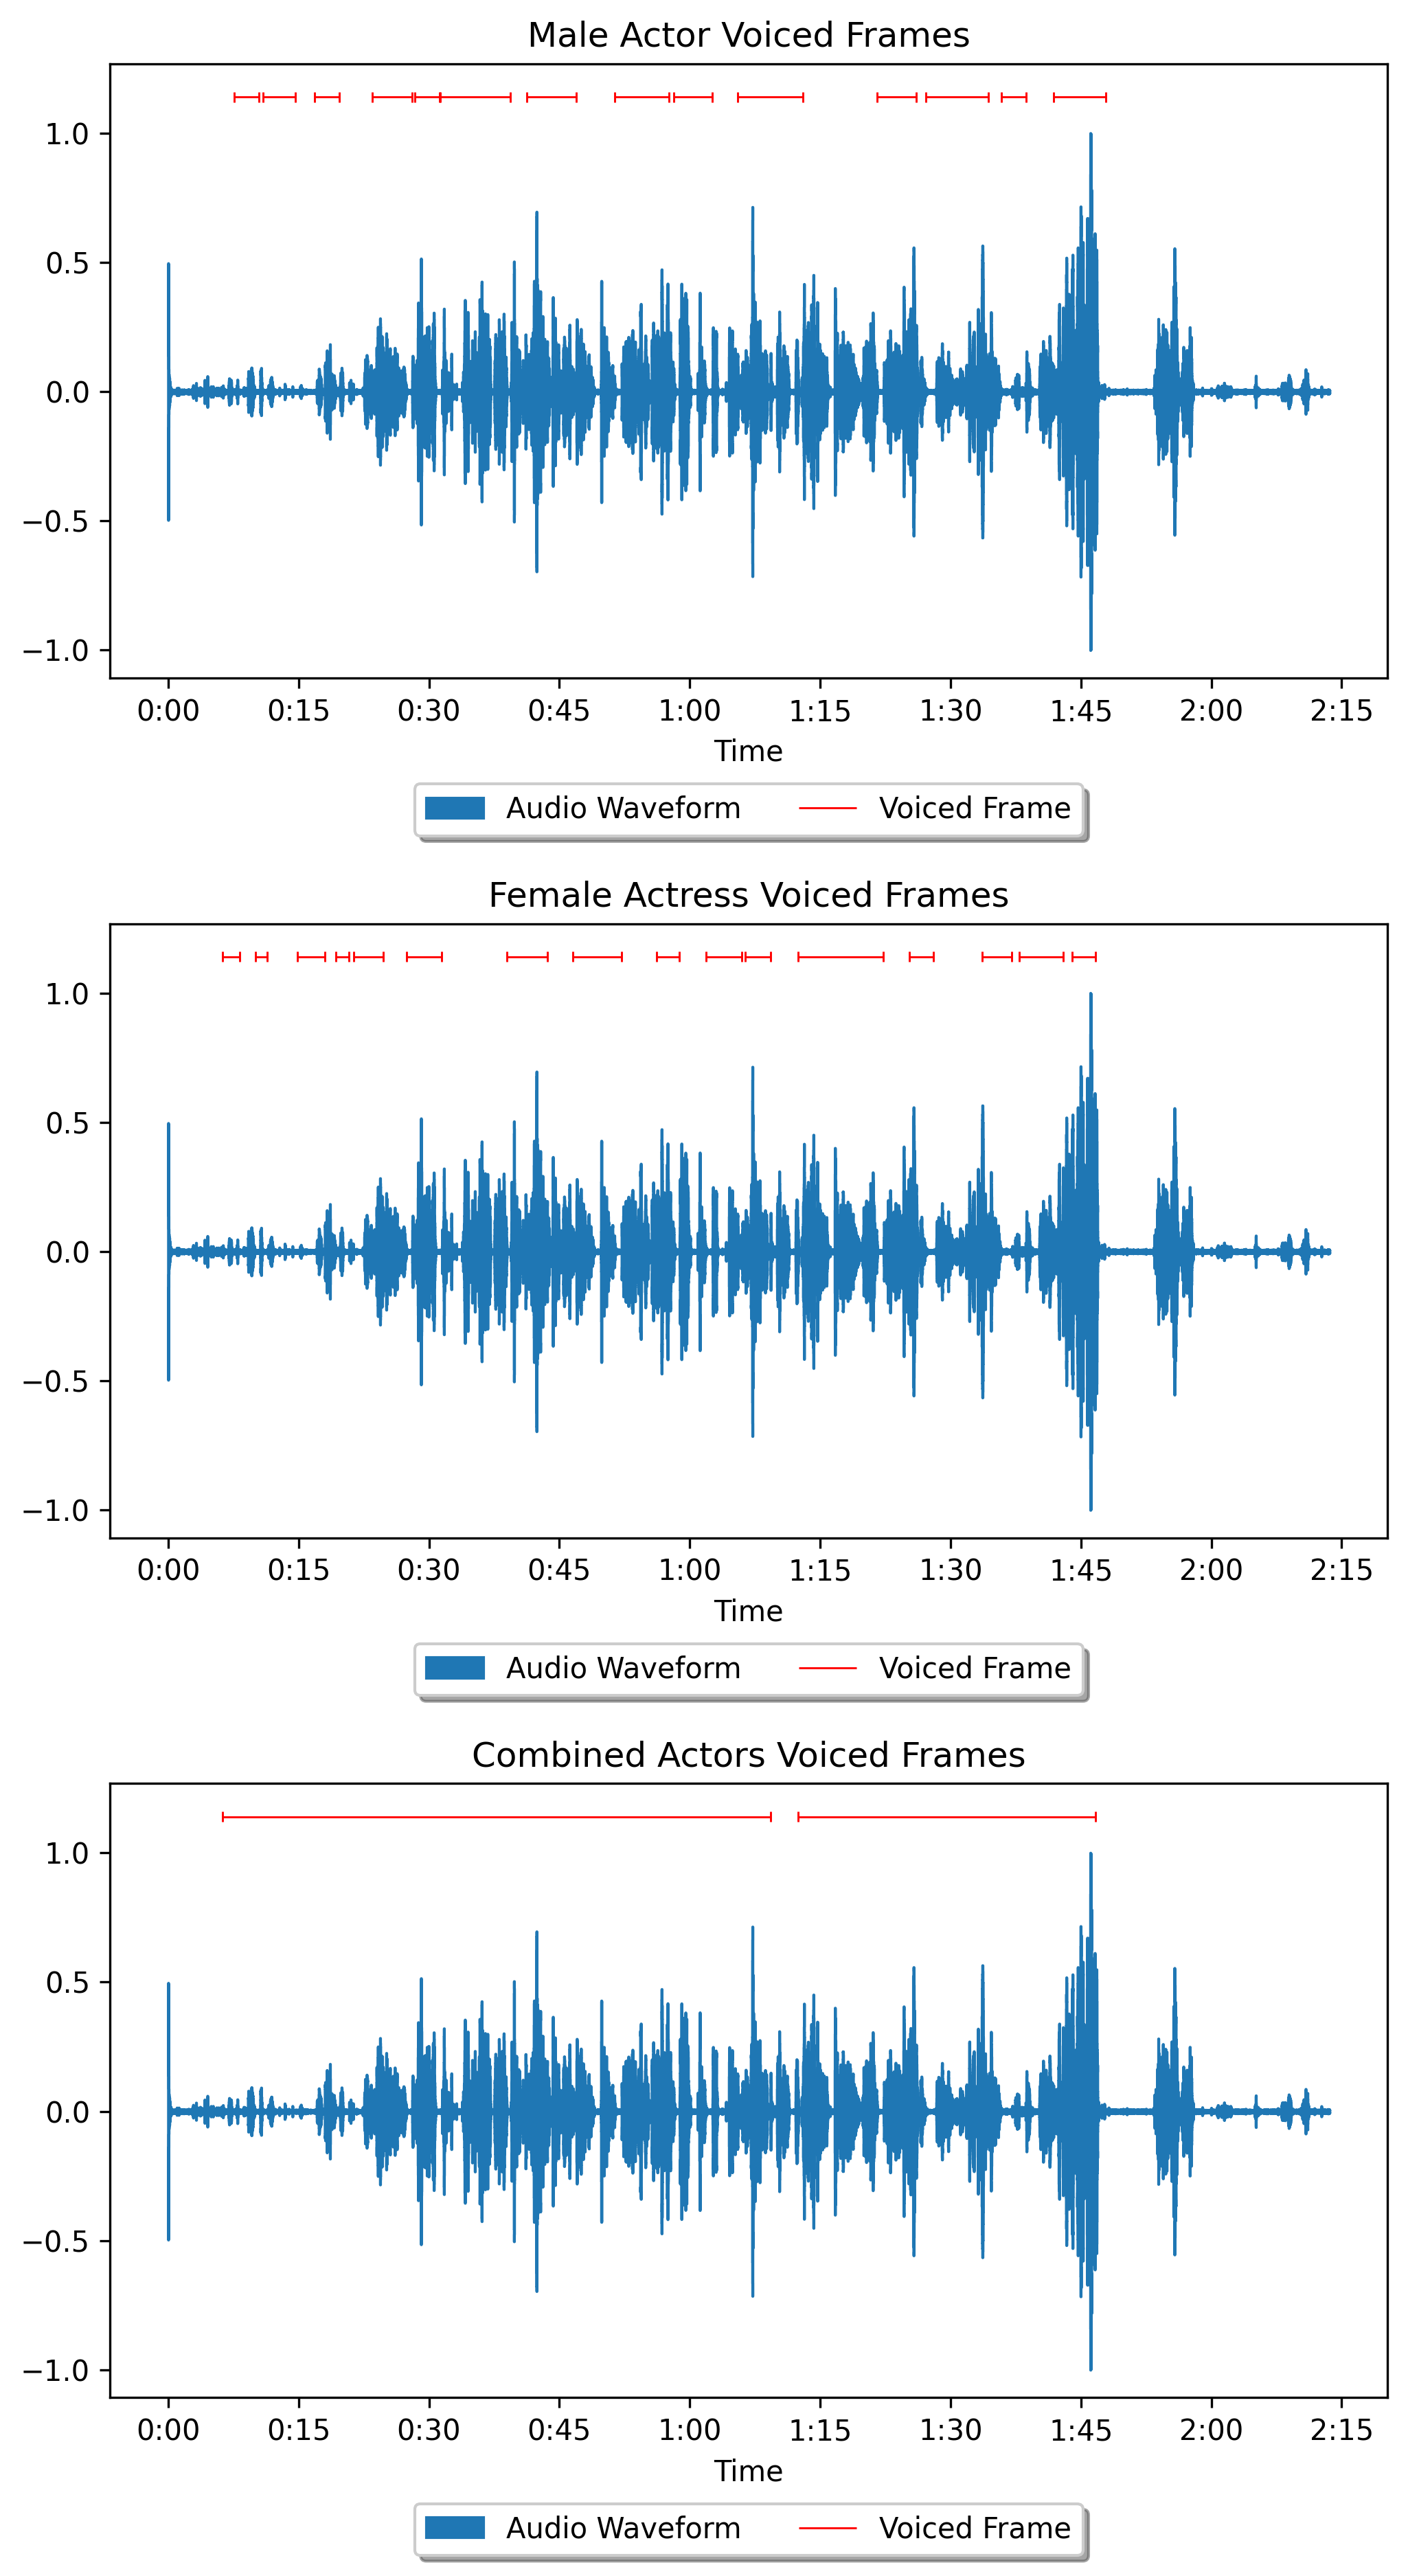

In [7]:
grid = plt.GridSpec(3, 1, wspace=.1, hspace=.4)
plt.figure(figsize=(8, 15))

display_graph(plt.subplot(grid[0, 0]), "Male Actor Voiced Frames", male_voiced_frames)
display_graph(plt.subplot(grid[1, 0]), "Female Actress Voiced Frames", female_voiced_frames)
display_graph(plt.subplot(grid[2, 0]), "Combined Actors Voiced Frames", combined_voiced_frames)

plt.show()

# Framing

In [8]:
def read_wav_part_from_local(path: str, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        fs = wavread.getframerate()
        start = int(start_s * fs)
        duration = int(duration_s * fs)
        wavread.setpos(start)
        wav_bytes = wavread.readframes(duration)
        
        if wavread.getsampwidth() == 2:
            dtype = 'int16'
        elif wavread.getsampwidth() == 4:
            dtype = 'int32'
        else:
            raise NotImplemented('Error Reading Sample')

        wav_array = np.frombuffer(wav_bytes, dtype=dtype)
        return wav_array, fs

## Silero

In [9]:
def int2float32(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/abs_max
    sound = sound.squeeze()
    return sound

model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)

pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

silero_voiced_frames = []
silero_confidences = []
step = 0.03 # duration in seconds
min_confidence = 0.7
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    if len(wav_array) == 960:
        confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

        silero_confidences.append(confidence)
        
        pp.update(confidence)

        end = start+step

        if confidence >= min_confidence:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_frame_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_frame_duration:
                    silero_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(silero_voiced_frames) and silero_voiced_frames[-1] != (prev_start, prev_end)) or ((not len(silero_voiced_frames)) and prev_end):
    if prev_end - prev_start > min_frame_duration:
        silero_voiced_frames.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


<IPython.core.display.Javascript object>

In [10]:
print("Execution time: 10 seconds")
print(f"Number of voice frames: {len(silero_voiced_frames)}")
print(silero_voiced_frames)

Execution time: 10 seconds
Number of voice frames: 10
[(6.27, 7.71), (9.209999999999999, 11.61), (15.75, 21.3), (22.529999999999998, 26.34), (27.45, 28.71), (29.91, 53.13), (54.33, 66.06), (67.25999999999999, 70.11), (71.25, 75.57), (76.77, 121.22999999999999)]


## WebRTCVAD

In [11]:
# strict mode
vad = webrtcvad.Vad(3)

pp = ProgressPlot(plot_names=["WebRTCVAD"], line_names=["speech probabilities"], x_label="audio chunks")

webrtcvad_voiced_frames = []
webrtcvad_confidences = []

step = 0.01 # duration in seconds
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    if webrtcvad.valid_rate_and_frame_length(fs, len(wav_array)):
        confidence = vad.is_speech(wav_array, fs)
        webrtcvad_confidences.append(confidence)

        pp.update(confidence)

        end = start+step

        if confidence == 1:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_frame_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_frame_duration:
                    webrtcvad_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(webrtcvad_voiced_frames) and webrtcvad_voiced_frames[-1] != (prev_start, prev_end)) or ((not len(webrtcvad_voiced_frames)) and prev_end):
    if prev_end - prev_start >= min_frame_duration:
        webrtcvad_voiced_frames.append((prev_start, prev_end))

<IPython.core.display.Javascript object>

In [12]:
print("Execution time: 11 seconds")
print(f"Number of voice frames: {len(webrtcvad_voiced_frames)}")
print(webrtcvad_voiced_frames)

Execution time: 11 seconds
Number of voice frames: 10
[(9.19, 12.07), (17.11, 21.1), (22.56, 32.71), (33.81, 48.69), (49.77, 87.08000000000001), (88.38, 95.74000000000001), (97.38, 106.95), (113.48, 117.99000000000001), (120.79, 122.22000000000001), (128.12, 129.23)]


## Results Overview

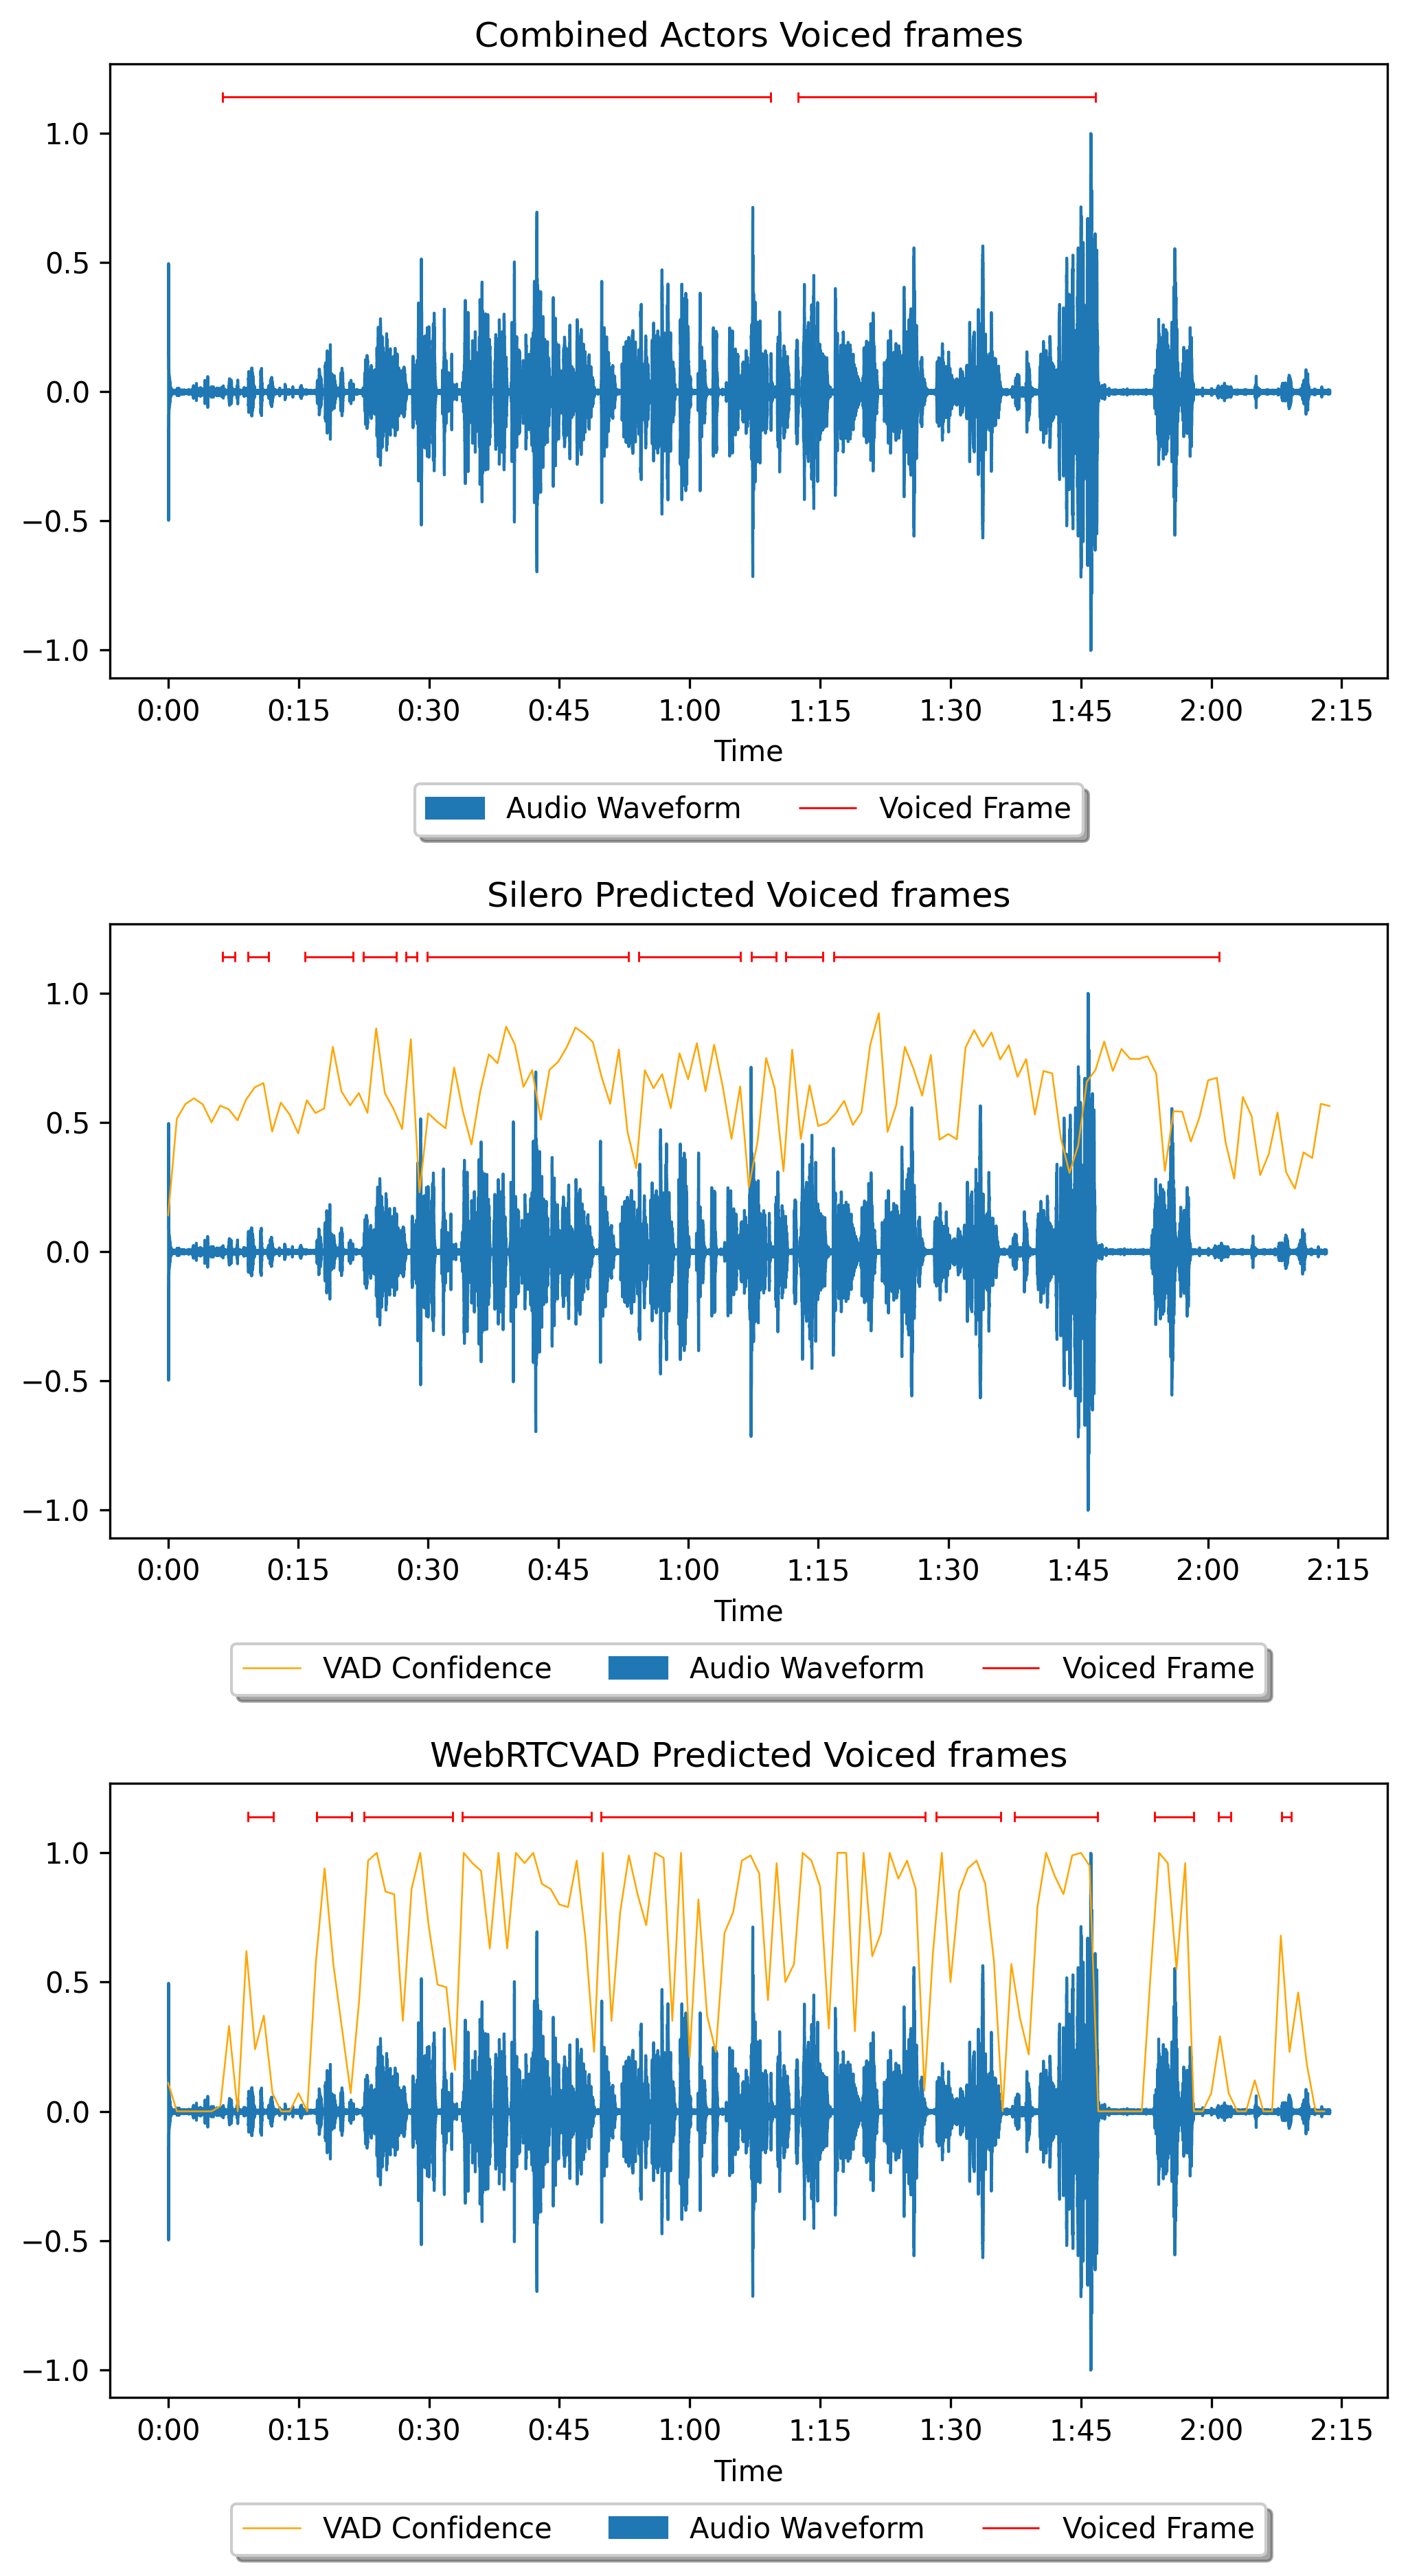

In [13]:
grid = plt.GridSpec(3, 1, wspace=.1, hspace=.4)
plt.figure(figsize=(8, 15))

display_graph(plt.subplot(grid[0, 0]), "Combined Actors Voiced frames", combined_voiced_frames)

ax = plt.subplot(grid[1, 0])
plt_confidences = []
for i in range(0, len(silero_confidences), 33):
    plt_confidences.append(np.mean(silero_confidences[i:i+33]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "Silero Predicted Voiced frames", silero_voiced_frames, 4)


ax = plt.subplot(grid[2, 0])
plt_confidences = []
for i in range(0, len(webrtcvad_confidences), 100):
    plt_confidences.append(np.mean(webrtcvad_confidences[i:i+100]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "WebRTCVAD Predicted Voiced frames", webrtcvad_voiced_frames, 4)

plt.show()

In [14]:
Audio(y[int(silero_voiced_frames[1][0]*sr):int(silero_voiced_frames[1][1]*sr)], sr)

In [15]:
Audio(y[int(webrtcvad_voiced_frames[0][0]*sr):int(webrtcvad_voiced_frames[0][1]*sr)], sr)

## Testing with Noise Reduction

In [16]:
import noisereduce as nr

model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)

pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

denoised_silero_voiced_frames = []
denoised_silero_confidences = []
step = 0.03 # duration in seconds
min_confidence = 0.7
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    wav_array = nr.reduce_noise(y=wav_array, sr=fs)
    if len(wav_array) == 960:
        confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

        denoised_silero_confidences.append(confidence)
        
        pp.update(confidence)

        end = start+step

        if confidence >= min_confidence:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_frame_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_frame_duration:
                    denoised_silero_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(denoised_silero_voiced_frames) and denoised_silero_voiced_frames[-1] != (prev_start, prev_end)) or ((not len(denoised_silero_voiced_frames)) and prev_end):
    if prev_end - prev_start > min_frame_duration:
        denoised_silero_voiced_frames.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


<IPython.core.display.Javascript object>

In [17]:
print("Execution time: 75 seconds")
print(f"Number of voice frames: {len(denoised_silero_voiced_frames)}")
print(denoised_silero_voiced_frames)

Execution time: 75 seconds
Number of voice frames: 10
[(1.29, 2.88), (4.59, 11.61), (17.099999999999998, 26.31), (27.45, 53.13), (54.3, 66.06), (67.14, 70.08), (71.25, 89.91), (91.11, 119.61), (125.72999999999999, 128.16), (129.39, 133.62)]


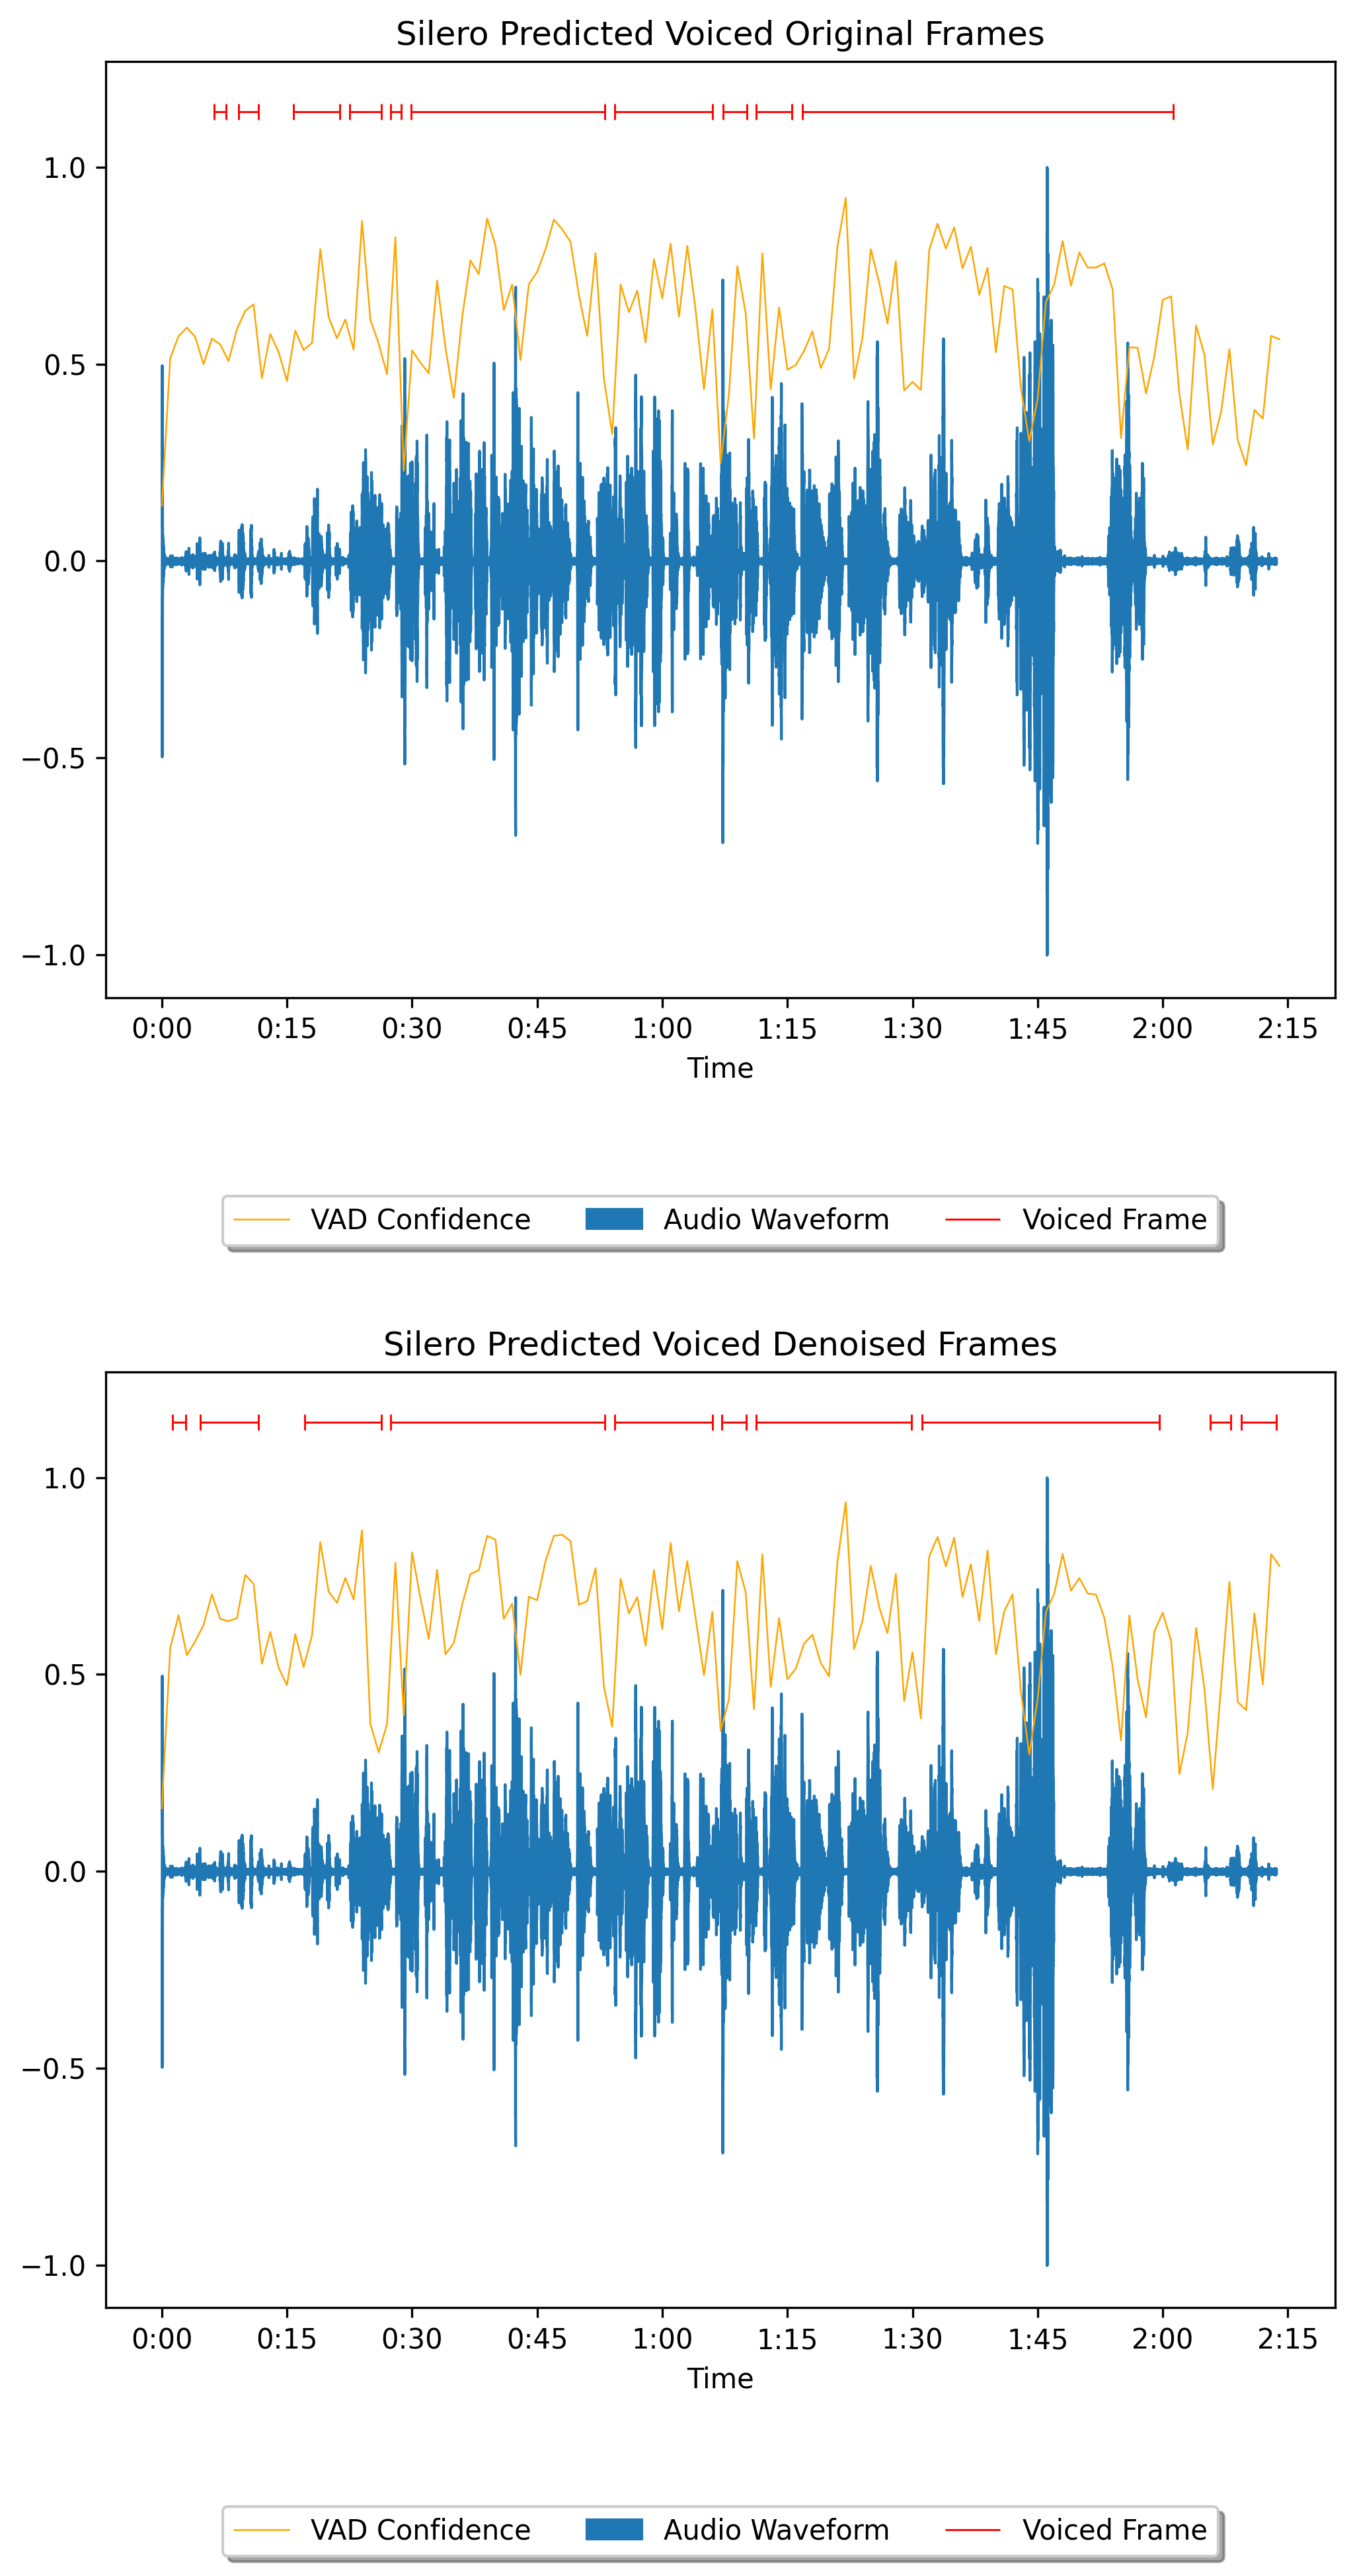

In [18]:
grid = plt.GridSpec(2, 1, wspace=.1, hspace=.4)
plt.figure(figsize=(8, 15))

ax = plt.subplot(grid[0, 0])
plt_confidences = []
for i in range(0, len(silero_confidences), 33):
    plt_confidences.append(np.mean(silero_confidences[i:i+33]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "Silero Predicted Voiced Original Frames", silero_voiced_frames, 4)


ax = plt.subplot(grid[1, 0])
plt_confidences = []
for i in range(0, len(denoised_silero_confidences), 33):
    plt_confidences.append(np.mean(denoised_silero_confidences[i:i+33]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "Silero Predicted Voiced Denoised Frames", denoised_silero_voiced_frames, 4)

plt.show()